This notebook creates the Logistic Regression weights table from the paper as well as a weights table for PoS which is not contained in the paper but is a useful reference.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
import pickle
import seaborn as sns
import json

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer

from matplotlib.lines import Line2D

Read in the AF Hoax Set data.

In [2]:
feats = pd.read_csv("../../System/feats_train.csv")

feats.set_index('index', inplace=True)

af = feats.loc[feats['class'] == 1]
naf = feats.loc[feats['class'] == 0]

labels = feats["class"]
feats.drop('class', axis=1, inplace=True)

Read in the Fake News Hoax Set data.

In [3]:
fakes = pd.read_csv("../../System/fake_news_feats_train.csv")
fakes.set_index('index', inplace=True)
fake_labels = fakes["class"]
fakes.drop('class', axis=1, inplace=True)

Read in the Bag-of-PoS data

In [4]:
bop = pd.read_csv("../../System/bop_train.csv")
bop.set_index('index', inplace=True)
bop.drop('class', axis=1, inplace=True)

fake_bop = pd.read_csv("../../System/fake_news_bop_train.csv")
fake_bop.set_index('index', inplace=True)
fake_bop.drop('class', axis=1, inplace=True)

Create a map of features to groups.

In [5]:
groups = ["complexity", "deception", "details", "formality"
                  ,"humour", "imagination", "vagueness"]

feat_group_map = dict()

for g in groups:
    with open("../../System/feature_sets/{}.txt".format(g)) as file:
        for line in file:
            if line.strip() in feats.columns:
                feat_group_map[line.strip()] = g

Create the classifiers/pipelines

In [6]:
classifier = LogisticRegression()
fake_news_classifier = LogisticRegression()
bop_classifier = LogisticRegression()
bop_fake_classifier = LogisticRegression()

# Create the pipelines
pipeline = Pipeline([
        ('normalizer', StandardScaler()),  # Step1 - normalize data
        ('clf', classifier)  # Step2 - classifier
        ])

fake_news_pipeline = Pipeline([
        ('normalizer', StandardScaler()),  # Step1 - normalize data
        ('clf', fake_news_classifier)  # Step2 - classifier
        ])

bop_pipeline = Pipeline([
        ('normalizer', StandardScaler()),  # Step1 - normalize data
        ('clf', bop_classifier)  # Step2 - classifier
        ])

bop_fake_pipeline = Pipeline([
        ('normalizer', StandardScaler()),  # Step1 - normalize data
        ('clf', bop_fake_classifier)  # Step2 - classifier
        ])

# Fit the pipeline for each feature set.
pipeline.fit(feats, labels)
fake_news_pipeline.fit(fakes, fake_labels)
bop_pipeline.fit(bop, labels)
bop_fake_pipeline.fit(fake_bop, fake_labels)

Pipeline(memory=None,
     steps=[('normalizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

Get the Logistic Regression weights.

In [7]:
# Gets the weights for the Logistic Regression
def get_weights(CLF, feats):
    coeffs = CLF.coef_.ravel()

    rank_pd = pd.DataFrame()
    rank_pd['Weights'] = coeffs
    rank_pd['Features'] = feats.columns.values
    rank_pd.set_index("Features", inplace=True)
    sorted_ranks = rank_pd.sort_values(by='Weights', ascending=False)
    return sorted_ranks
    
sorted_ranks = get_weights(classifier, feats)
sorted_fake_ranks = get_weights(fake_news_classifier, fakes)
sorted_bop = get_weights(bop_classifier, bop)
sorted_fake_bop = get_weights(bop_fake_classifier, fake_bop)

Plot the weights for the hoax set.

In [8]:
# Plot LR weights given a table of weights..
def plot_weights(weight_pd):
    fig, ax = plt.subplots(figsize=(5, 12))

    y_pos = np.arange(len(weight_pd.index))[::-1]

    # lambda used to decide which colour to make a bar baed on pos/neg.
    colour_lambda = lambda x: "#abd9e9" if x>0 else '#fdae61'

    # Load in map of names so we can use readable feature names.
    name_map = json.load(open("../name_map.json"))
    feat_names = [name_map[x] for x in weight_pd.index]
    grouped_names = []
    
    # Rename the features so they're more readable (ie with capitals and spaces, etc)
    for fancy_name, rubbish_name in zip(feat_names, weight_pd.index):
        new_name = "{} ({})".format(fancy_name, feat_group_map[rubbish_name][:3])
        grouped_names.append(new_name)

    # Make the bars
    bars = ax.barh(y_pos, weight_pd.Weights, color=weight_pd.Weights.apply(colour_lambda), zorder=3)

    # Label the graph.
    ax.set_yticks(y_pos)
    ax.set_yticklabels(grouped_names)

    ax.grid(b=True, axis='y', zorder=0, alpha=0.5)
    plt.show()

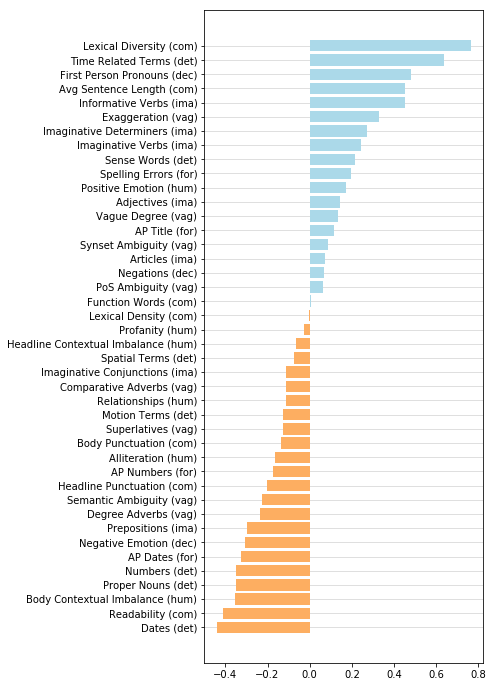

In [9]:
# Do a plot for weights of Hoax Set for AF
plot_weights(sorted_ranks)

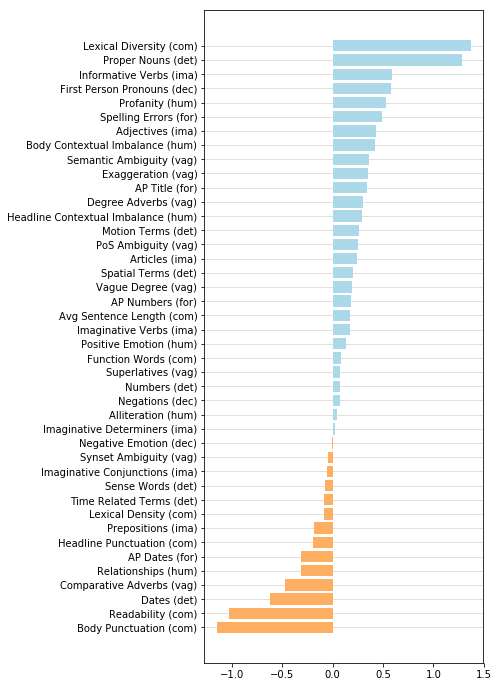

In [10]:
# Do a plot for weights of Hoax Set for AF
plot_weights(sorted_fake_ranks)

Plot the weights for the Bag-of-Part-of-Speech

In [11]:
# choose only top and bottom 20 weights.
reduced_bop = sorted_bop.iloc[np.r_[0:20, -20:0]]
reduced_fake_bop = sorted_fake_bop.iloc[np.r_[0:20, -20:0]]

# Plot LR weights given a table of weights.
def plot_bop_weights(weight_pd):
    fig, ax = plt.subplots(figsize=(5, 10))

    y_pos = np.arange(len(weight_pd.index))[::-1]
    colour_lambda = lambda x: "#abd9e9" if x>0 else '#fdae61'
    
    # Make bars and label.
    bars = ax.barh(y_pos, weight_pd.Weights, color=weight_pd.Weights.apply(colour_lambda))
    ax.set_yticks(y_pos)
    ax.set_yticklabels(weight_pd.index)

    plt.show()

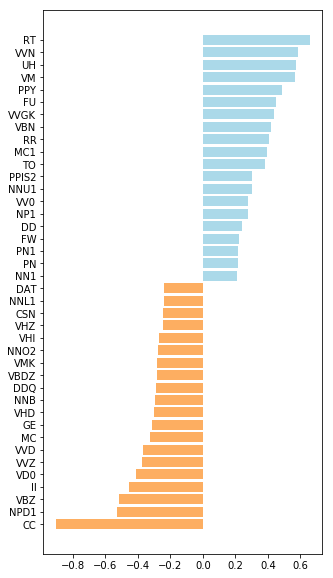

In [12]:
# Do a plot for weights of Parts-of-Speech for AF
plot_bop_weights(reduced_bop)

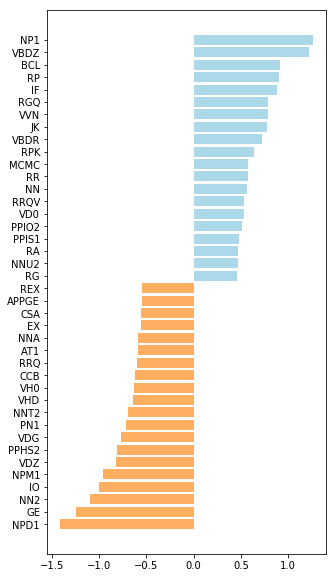

In [13]:
# Do a plot for weights of Parts-of-Speech for Fake News
plot_bop_weights(reduced_fake_bop)